In [1]:
from environment import GridWorld

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd

### (I)

In [3]:
def get_policy(param, sigma):
    policy = np.exp(param*sigma)
    temp = np.exp(param*sigma)
    for i in range(0, policy.shape[0]):
        row_sum = temp[i].sum();
        for j in range(0, policy.shape[1]):
            policy[i][j] = policy[i][j]/ row_sum
    return policy

In [4]:
def get_return_over_episode(policy, sigma):
    env = GridWorld() 
    episode_return = env.reward
    while(not env.is_end_state()):

        (st, rw) = env.take_step(policy)
      
        episode_return += env.reward

    return episode_return    

In [5]:
def run_trial(params, sigma):
    policy = get_policy(np.reshape(params, (25, 4)), sigma)

    return_sum = 0
    for j in range(30):
        return_sum += get_return_over_episode(policy, sigma)
    avg_return = return_sum / 30 

    return avg_return

In [6]:
def run_trials(sigma):
    params = np.random.normal(0, 1, (100))
    avg_return_old = run_trial(params, sigma)
    gains = []
    gains.append(avg_return_old)
    for i in range(1000):
        
        new_params = np.random.multivariate_normal(params, sigma*np.identity(100))
     
        avg_return_new = run_trial(new_params, sigma)
        gains.append(avg_return_new)
        if(avg_return_new > avg_return_old):

            params = new_params
            avg_return_old = avg_return_new

    return (gains, params)
        

In [12]:
(g, p) = run_trials(0.976)

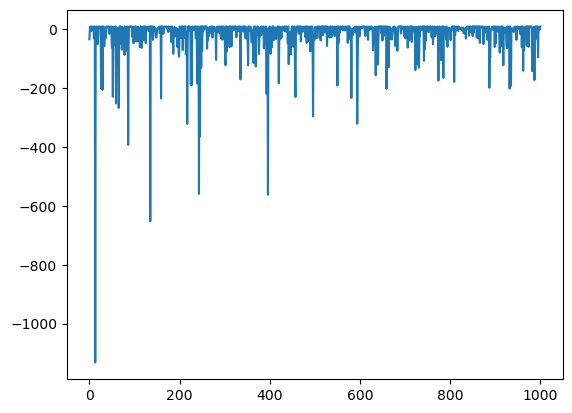

In [16]:
plt.plot(g)

In [17]:
g = []
for i in range(300):
    g.append(run_trial(p, 0.976))

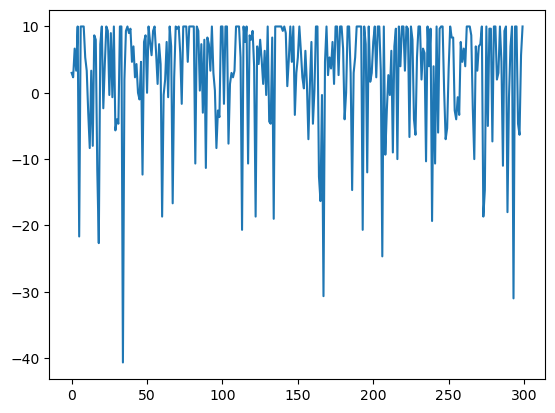

In [18]:
plt.plot(g)

### (II)